# **Нелинейные модели против южной погоды**

Компания BikeSouth, оператор городского велопроката на черноморском побережье России, хочет улучшить систему прогнозирования почасового спроса на велосипеды.

До этого аналитики компании использовали простую линейную регрессию. Однако её прогнозы часто были неточными. Погода на море меняется быстро, поэтому у многих признаков нелинейная взаимосвязь. Температура, влажность, солнечная радиация, осадки и другие факторы могут на одном промежутке значений влиять на целевую (и не только) переменную определённым образом, а на другом — уже совершенно иным.

Цель проекта - предложить компании BikeSouth новую, более гибкую модель для прогнозирования спроса на велосипеды.


Данные:
- Temperature - Температура воздуха в градусах Цельсия (°C).

- Humidity - Относительная влажность воздуха.

- Windspeed - Скорость ветра.

- Visibility - Видимость (в десятках метров).

- Dew Point Temperature - Точка росы (°C).

- Solar Radiation - Солнечная радиация (MJ/m²).

- Rainfall - Количество осадков (мм).

- Snowfall - Количество снега (см).

- Seasons - Времена года: Winter, Spring, Summer, Autumn.

- Holiday - Был ли в этот день выходной или праздничный день.

- Functioning Day - Были ли велосипеды арендованы в рабочее время.

- Time_Period (Несколько колонок) - Каждая запись в датасете относится к одному из пяти временных периодов:

- Night — c 00:00 по 05:59;

* Morning — с 06:00 по 09:59.
- Daytime — с 10:00 по 15:59.
- Evening — с 16:00 по 19:59;
- Late Evening — с 20:00 по 23:59.


Ключевые шаги:

1) Изучить предоставленную компанией baseline-модель — линейную регрессию.

2) Обучить новые модели — kNN и дерево решений.

3) Провести подбор гиперпараметров с помощью библиотеки Optuna.

4) Сравнить результаты всех подходов, выбрать лучший и аргументировать выбор.

Постановка ml-задачи:
1) вид решаемой задачи - Регрессия

2) Целевая переменная Rented Bike Count - количество,

3) Модель должна выдавать стабильные паказатели работы как на тренеровочном так и на тестовом наборе данных

4) Также R2 должен быть не меньше чем у базовой модели

6) Дополнительные метрики качества модели MSE и MAE

In [1]:
# Ячейка 1: Установка
!pip install optuna -q
!pip uninstall -y pandas numpy scikit-learn joblib -q
!pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.6.1 joblib==1.3.2 phik -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


Чтож начнём знакомство с базовой моделью предоставленной компанией 'BikeSouth'. Модель уже обучена поэтому посмотрим её метрики на тестовых данных.

In [2]:
# Импортируйте Optuna
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold # Added KFold

import optuna

import pandas as pd 
import joblib
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor

In [3]:

test_df = pd.read_csv('/datasets/ds_s14_test_data.csv')
X = test_df.drop(columns=['Rented Bike Count'])
y = test_df['Rented Bike Count']

# Используйте joblib для загрузки модели
model_base = joblib.load('/datasets/baseline_linear_regression_pipeline.pkl')

pred = model_base.predict(X)

bas_mae = round(mean_absolute_error(y, pred), 3)
bas_mse = round(mean_squared_error(y, pred), 3)
bas_r2 = round(r2_score(y, pred), 3)

print(f"r2 Score: {bas_r2}")
print(f"MSE Score: {bas_mse}")
print(f"MAE Score: {bas_mae}")

r2 Score: 0.586
MSE Score: 169384.999
MAE Score: 312.599


Метрики показывают не лучший результат базовой модели, R2 = 0.58 что является почти угадыванием модель плохо объясняет данные но эти значения должны стать "отправной точкой" для результатов будущих моделей  

## **Часть 2. Улучшение модели — kNN и дерево решений**

In [4]:
df = pd.read_csv('/datasets/ds_s14_train_data.csv')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature               7008 non-null   float64
 1   Humidity(%)               6758 non-null   float64
 2   Wind speed (m/s)          6798 non-null   float64
 3   Visibility (10m)          6749 non-null   float64
 4   Dew point temperature     7008 non-null   float64
 5   Solar Radiation (MJ/m2)   6798 non-null   float64
 6   Rainfall(mm)              6746 non-null   float64
 7   Snowfall (cm)             6745 non-null   float64
 8   Seasons                   7008 non-null   object 
 9   Holiday                   7008 non-null   object 
 10  Functioning Day           7008 non-null   object 
 11  Time_Period_Evening       7008 non-null   bool   
 12  Time_Period_Late Evening  7008 non-null   bool   
 13  Time_Period_Morning       7008 non-null   bool   
 14  Time_Per

,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Time_Period_Evening,Time_Period_Late Evening,Time_Period_Morning,Time_Period_Night,Rented Bike Count
0,20.3,35.0,2.4,2000.0,4.3,0.46,0.0,0.0,Autumn,Holiday,Yes,True,False,False,False,1237
1,25.4,55.0,3.2,2000.0,15.6,0.15,0.0,0.0,Autumn,No Holiday,Yes,True,False,False,False,2468
2,-6.9,39.0,1.6,2000.0,-18.5,0.00,0.0,0.0,Winter,No Holiday,Yes,False,True,False,False,186


Мы имеем обучающий датасет из 15 признаков. Некоторые содержат всего 2 категории что можно преобразовать в 0 и 1, некоторые имеют пропуски поэтому для категориальных будет созданна отдельная категория unknown а для числовых медианное значение или глушилка -9999. Также аоизбежание глупой ловушки нужно избавиться от столбца Time_Period_Morning поскольку все Time_Period_ взаимоисключают друг друга.

In [5]:
df = df.drop(columns = ['Time_Period_Morning'])
for i in ['Holiday', 'Time_Period_Late Evening', 'Time_Period_Evening', 'Time_Period_Night','Functioning Day']:
    df[i] = df[i].replace({
    "True": 1,
    "False": 0,
    "Holiday": 1,
    "No Holiday": 0,
    "Yes": 1,
    "No": 0
}).astype(bool)

/tmp/ipykernel_49/2206476854.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df[i].replace({
/tmp/ipykernel_49/2206476854.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df[i].replace({




---



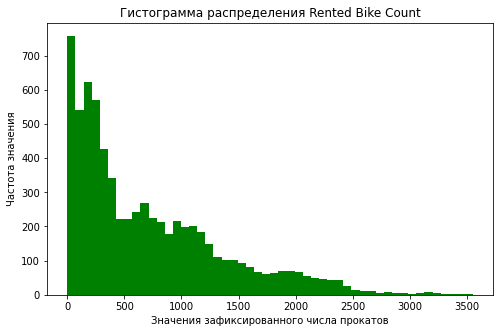

count    7008.000000
mean      705.606022
std       646.311790
min         0.000000
25%       190.750000
50%       504.500000
75%      1070.000000
max      3556.000000
Name: Rented Bike Count, dtype: float64

In [6]:
#изучим распределение целевой переменной
plt.figure(figsize=(8, 5))
# Создаём гистограмму с 30 интервалами (бинами)
plt.hist(df['Rented Bike Count'], bins=50, color="green")

# Подписываем ось X
plt.xlabel("Значения зафиксированного числа прокатов")

# Подписываем ось Y
plt.ylabel("Частота значения")

# Задаём заголовок графика
plt.title("Гистограмма распределения Rented Bike Count")

# Показываем график
plt.show()

df['Rented Bike Count'].describe()

По графику видно что чаще всего значения около 0, медиана 504 арендованых велосипеда лишь изредка значение превышает 2500. Возможно это сезонные колебания ведь в дождь, снег, град... спрос резко падает.

Средний спрос по сезонам:
Seasons
Summer    1046.247133
Autumn     820.644068
Spring     725.046075
Winter     226.417627
Name: Rented Bike Count, dtype: float64

Средний спрос: Праздники vs Будни:
Holiday
False    716.401920
True     493.879412
Name: Rented Bike Count, dtype: float64


/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


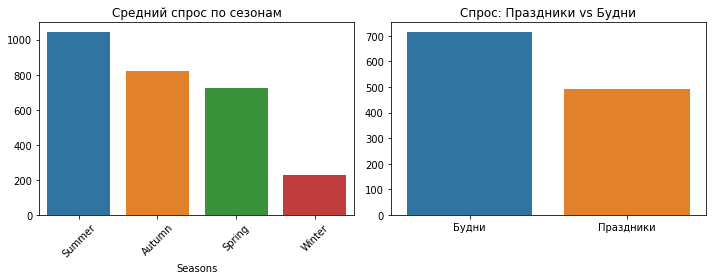

In [7]:
# Средний спрос по сезонам
season_demand = df.groupby('Seasons')['Rented Bike Count'].mean().sort_values(ascending=False)
print("Средний спрос по сезонам:")
print(season_demand)

# Средний спрос по праздникам
holiday_demand = df.groupby('Holiday')['Rented Bike Count'].mean()
print("\nСредний спрос: Праздники vs Будни:")
print(holiday_demand)

# График 1: Спрос по сезонам
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=season_demand.index, y=season_demand.values)
plt.title('Средний спрос по сезонам')
plt.xticks(rotation=45)

# График 2: Спрос по праздникам
plt.subplot(1, 2, 2)
sns.barplot(x=['Будни', 'Праздники'], y=holiday_demand.values)
plt.title('Спрос: Праздники vs Будни')

plt.tight_layout()
plt.show()

Видно что наибольший спрос на велосипеды приходится на лето и будние дни возможно в жаркую погоду люди предпочитают кататься а не ездить на транспорте.

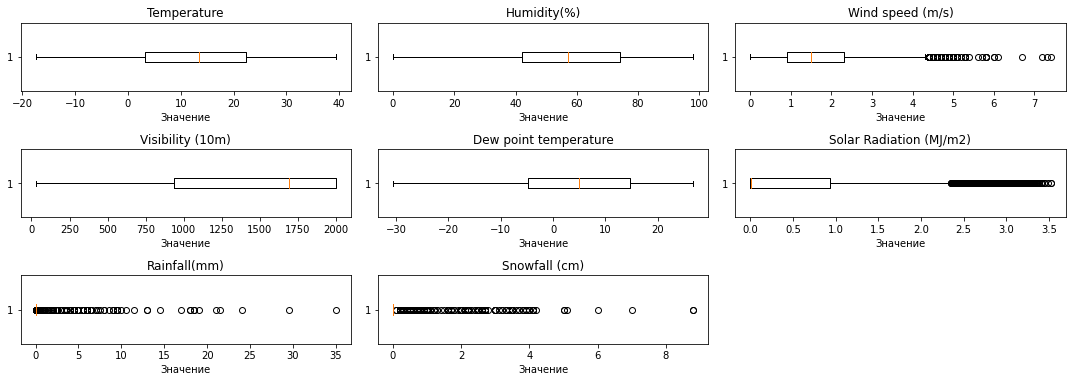

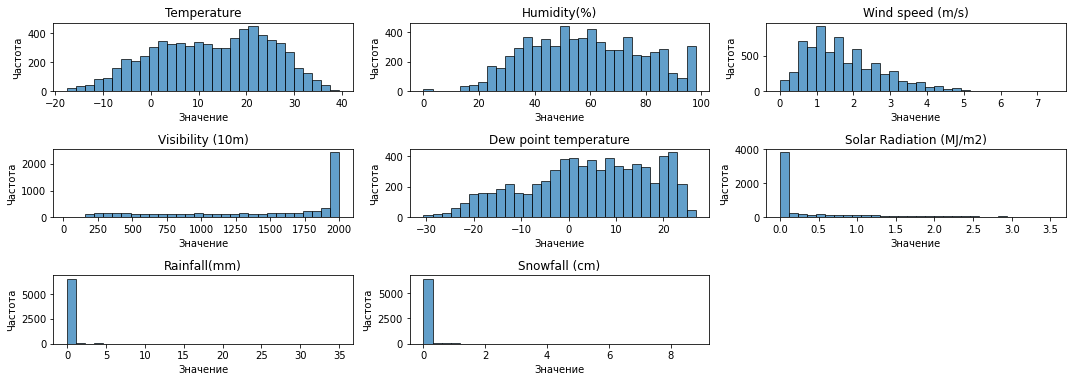

In [8]:
numeric_features = df.select_dtypes(include=['float64']).columns.tolist()
fig, axes = plt.subplots(7, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    axes[i].boxplot(df[col].dropna(), vert=False)
    axes[i].set_title(col)
    axes[i].set_xlabel('Значение')

# Убираем пустые графики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Гистограммы распределений
fig, axes = plt.subplots(7, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')

# Убираем пустые графики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Все числовые признаки имеют в своём составе редкие, но вполне реальные значения. Выбросов нет.

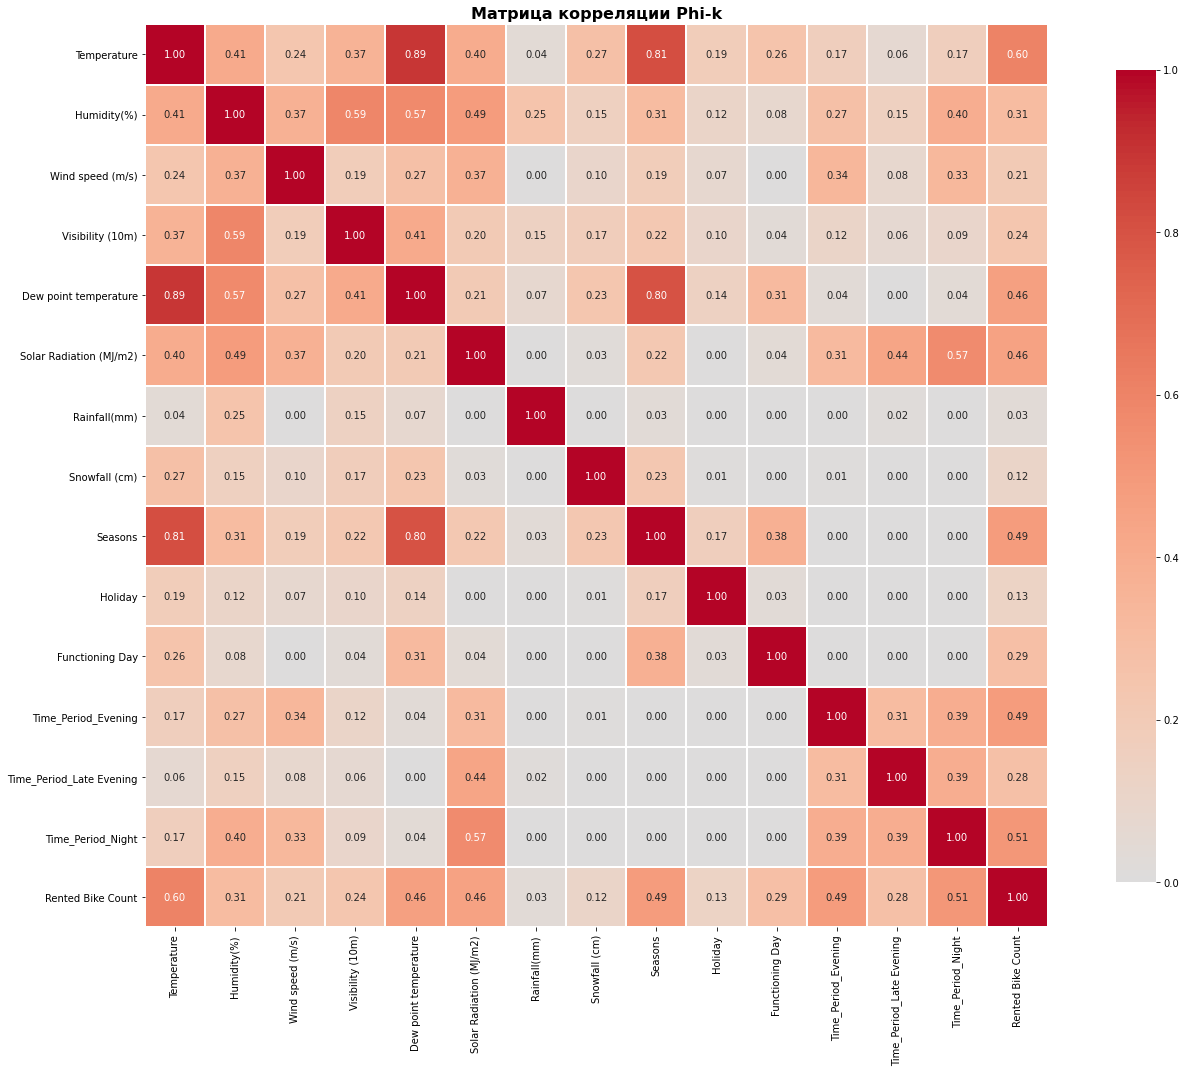

In [9]:

phik_overview = df.phik_matrix(interval_cols=['Temperature', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Rented Bike Count'])
plt.figure(figsize=(20, 15))
sns.heatmap(phik_overview, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={'shrink': 0.9})
plt.title('Матрица корреляции Phi-k', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Из матрицы видно что больше всего со спросом на прокат коррелируют: температура 0.6, ночь 0.51 и сезон года 0.49.

**Шаг 2. Разделение данных на тренировочную и валидационную выборки**

Используйте на этом этапе данные файла `ds_s14_train_data.csv`. Тестовый набор нужен только для финальной оценки модели после обучения и подбора гиперпараметров.

Подготовка данных вам понадобится, чтобы обучить модель и оценить её качество через валидацию.

---



In [10]:
df = pd.read_csv('/datasets/ds_s14_train_data.csv')

X_train = df.drop(columns=['Rented Bike Count'])
y_train = df['Rented Bike Count']


**Шаг 3. Обучение новых моделей**

kNN и деревья решений могут уловить нелинейные зависимости, недоступные линейной регрессии. Пора это проверить!

1. Подготовьте пайплайн для каждой модели:
    * Выполните предобработку данных.
    * Инициализизируйте регрессионные модели kNN и дерево решений.
4. Настройте базовые параметры моделей — например, `n_neighbors` для kNN, `max_depth` для дерева.

**Совет:**

Начинайте с базовых параметров, чтобы убедиться, что пайплайн работает. Оптимизацию параметров вы сделаете на следующем шаге.

---



In [11]:
#сначала удаляем и приводим к бинарным потом работа с пропусками и масштабирование
def custom_transform(df):
    df = df.copy()
    
    if 'Time_Period_Morning' in df.columns:
        df = df.drop(columns=['Time_Period_Morning'])
    
    columns_to_convert = [
        'Holiday', 
        'Time_Period_Late Evening', 
        'Time_Period_Evening', 
        'Time_Period_Night',
        'Functioning Day'
    ]
    
    replacement_dict = {
        "True": True,      # Replace with Python boolean `True`
        "False": False,    # Replace with Python boolean `False`
        "Holiday": True,
        "No Holiday": False,
        "Yes": True,
        "No": False
    }
    
    for col in columns_to_convert:
        if col in df.columns:
            # 1. First, convert the entire column to the desired type.
            # Pandas `'bool'` dtype is efficient for True/False data.
            df[col] = df[col].astype('bool')
            # 2. Now perform the replacement. Since the column is already `bool`,
            # pandas won't need to downcast.
            df[col] = df[col].replace(replacement_dict)
    
    return df
# Создаем FunctionTransformer
custom_transformer = FunctionTransformer(custom_transform)


In [12]:



numerical_features = ['Temperature', 'Humidity(%)', 'Wind speed (m/s)', 
                      'Visibility (10m)', 'Dew point temperature', 
                      'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

categorical_features = ['Seasons']  # Остальные стали булевыми

# Создаем полный Pipeline knn
knn_pipeline = Pipeline([
    ('custom_transform', custom_transformer),
    
    ('preprocessing', ColumnTransformer([
        # Для числовых признаков: сначала импутация, потом масштабирование
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        
        # Для категориальных: только OneHotEncoder
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')),  # Булевые признаки проходят как есть
    
    ('model', KNeighborsRegressor(n_neighbors=3))
])




# Создаем полный Pipeline решающее дерево
tree_pipeline = Pipeline([
    ('custom_transform', custom_transformer),
    
    ('preprocessing', ColumnTransformer([
        # Для дерева можно оставить только импутацию
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')),
    
    ('model', DecisionTreeRegressor(max_depth=10, random_state=42))  # Используем DecisionTreeRegressor
])



По итогу у нас есть 2 готовых пайплайна с KNN моделью и решающим деревом. Теперь можно подобрать к ним оптимальные гипперпараметриы и сравнить MAE

**Шаг 4. Подбор гиперпараметров с Optuna**

Компания хочет точную модель. Optuna поможет найти лучшие гиперпараметры для kNN и дерева, чтобы снизить ошибки прогноза.


1. Определите функцию цели для Optuna.

2. Настройте диапазоны гиперпараметров.

3. Запустите оптимизацию и сохраните лучшие параметры.

**Совет:**

Не бойтесь сначала экспериментировать с небольшими диапазонами, а потом расширять их, если модель не уловит зависимости.

---



In [ ]:

#функция для knn
def obj_knn(trial):
    # Пространство поиска гиперпараметров
    params = {
        "metric": trial.suggest_categorical("metric",['minkowski']),
        "p": trial.suggest_int('p', 1, 5),
        "n_neighbors": trial.suggest_int('n_neighbors', 1, 60),
        "weights":trial.suggest_categorical("weights", ['uniform', 'distance'])
    }
    
    model = KNeighborsRegressor(**params)

    pipeline = Pipeline([
        ('custom_transform', custom_transformer),
        ('preprocessing', ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ], remainder='passthrough')),
        ('model', model)
    ])

    scorer = make_scorer(mean_absolute_error)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
  
    scores = cross_val_score(
    pipeline, # Пайплайн
    X_train, # Признаки
    y_train, # Целевая переменная
    cv=cv, # Ранее созданная 5-фолдовая KFold кросс-валидация
    scoring=scorer # Передайте scorer 
    )

    return scores.mean()

# Запуск исследования
# Фиксируем сид через самплер
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(obj_knn, n_trials=50, show_progress_bar=True)

# Лучшие гиперпараметры и качество
knn_best_params = study.best_params
print("Лучшие гиперпараметры:", knn_best_params)
knn_best_value = study.best_value
print("Лучшее среднее значение MAE на кросс-валидации:", knn_best_value)

[I 2026-02-12 12:32:45,245] A new study created in memory with name: no-name-a0fa554b-2a8e-4a26-b6c8-0952d4136903


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-12 12:32:46,080] Trial 0 finished with value: 260.23394680524643 and parameters: {'metric': 'minkowski', 'p': 2, 'n_neighbors': 58, 'weights': 'uniform'}. Best is trial 0 with value: 260.23394680524643.


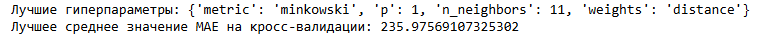

In [ ]:

def obj_tree(trial):
    # Пространство поиска гиперпараметров
    params = {
        "max_depth": trial.suggest_int('max_depth', 3, 15),
        "min_samples_split": trial.suggest_int('min_samples_split', 2, 50),
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 1, 20),
        "max_leaf_nodes":trial.suggest_int("max_leaf_nodes", 5,100)
    }
    
    model = DecisionTreeRegressor(random_state= 42, **params)

    pipeline =Pipeline([
    ('custom_transform', custom_transformer),
    
    ('preprocessing', ColumnTransformer([
        # Для дерева можно оставить только импутацию
        ('num', SimpleImputer(fill_value = -9999), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')),
    
    ('model', model)])
    scorer = make_scorer(mean_absolute_error)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
  
    scores = cross_val_score(
    pipeline, # Пайплайн
    X_train, # Признаки
    y_train, # Целевая переменная
    cv=cv, # Ранее созданная 5-фолдовая KFold кросс-валидация
    scoring=scorer # Передайте scorer 
    )

    return scores.mean()

# Запуск исследования
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(obj_tree, n_trials=60, show_progress_bar=True) # Напишите ваш код для запуска study здесь

# Лучшие гиперпараметры и качество
tree_best_params = study.best_params
print("Лучшие гиперпараметры:", tree_best_params)
tree_best_value = study.best_value
print("Лучшее среднее значение MAE на кросс-валидации:", tree_best_value)

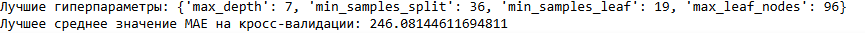

Видно что KNN модель справилась чуть лучше решающего дерева.

In [ ]:
#Выполним кросвалидацию для knn
knn_mod = KNeighborsRegressor(**knn_best_params)

knn = Pipeline([
    ('custom_transform', custom_transformer),
    ('preprocessing', ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ], remainder='passthrough')),
    ('model', knn_mod)
])

# 2. Настраиваем кросс-валидацию
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Создаем несколько скореров для оценки
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# 3. Кросс-валидация для kNN

knn_scores = cross_validate(
    knn,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Вычисляем средние метрики (MAE и MSE нужно сделать положительными)
knn_mae_mean = -knn_scores['test_MAE'].mean()
knn_mae_std = knn_scores['test_MAE'].std()
knn_mse_mean = -knn_scores['test_MSE'].mean()
knn_rmse_mean = np.sqrt(knn_mse_mean)
knn_r2_mean = knn_scores['test_R2'].mean()
knn_r2_std = knn_scores['test_R2'].std()

print(f"MAE: {knn_mae_mean:.2f} (±{knn_mae_std:.2f})")
print(f"MSE: {knn_mse_mean:.2f}")
print(f"RMSE: {knn_rmse_mean:.2f}")
print(f"R²:  {knn_r2_mean:.4f} (±{knn_r2_std:.4f})")


Показатели не идеальные но лучше чем у линейной модели. R2=0.7 - высокая объясняющая способность. MAE 235 +-5 тоже хороший показатель, модель не переобучена поэтому минимальные отклонения допустимы.

In [ ]:
#Выполним кросвалидацию для knn
model = DecisionTreeRegressor(random_state= 42, **tree_best_params)

tre=Pipeline([
('custom_transform', custom_transformer),
('preprocessing', ColumnTransformer([
    ('num', SimpleImputer(fill_value=-9999), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
], remainder='passthrough')),
('model', model)])

# 2. Настраиваем кросс-валидацию
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Создаем несколько скореров для оценки
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# 3. Кросс-валидация для kNN

knn_scores = cross_validate(
    tre,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Вычисляем средние метрики (MAE и MSE нужно сделать положительными)
tre_mae_mean = -knn_scores['test_MAE'].mean()
tre_mae_std = knn_scores['test_MAE'].std()
tre_mse_mean = -knn_scores['test_MSE'].mean()
tre_rmse_mean = np.sqrt(knn_mse_mean)
tre_r2_mean = knn_scores['test_R2'].mean()
tre_r2_std = knn_scores['test_R2'].std()

print(f"MAE: {tre_mae_mean:.2f} (±{tre_mae_std:.2f})")
print(f"MSE: {tre_mse_mean:.2f}")
print(f"RMSE: {tre_rmse_mean:.2f}")
print(f"R²:  {tre_r2_mean:.4f} (±{tre_r2_std:.4f})")

Решающее дерево немного стабильней но метрики(MAE и R2) чуть похуже чем у KNN модели

In [ ]:
res_df = pd.DataFrame(data = [[bas_mae, knn_mae_mean, tre_mae_mean],[bas_mse, knn_mse_mean, tre_mse_mean], [bas_r2,knn_r2_mean,tre_r2_mean]],
                      index =['MAE', "MSE", "R2"],
                     columns=['base', 'KNN', "Tree"])
res_df

KNN показывает наилучшие результаты по всем метрикам:

1) MAE 235.98 в среднем ошибается на 236 велосипедов (на 10 меньше, чем дерево)

2) R² 0.698 объясняет почти 70% дисперсии данных

Decision Tree находится на втором месте:

1) Всего на 4% хуже по R², чем KNN

2) MAE 246.08 → ошибка на 246 велосипедов в среднем

Baseline (Linear Regression) значительно хуже:

1) Объясняет только 58.6% дисперсии

2) Ошибка на 313 велосипедов в среднем

Практическая интерпретация: Если компания использует KNN вместо базовой линейной регрессии, она может сократить ошибку прогнозирования на ~25% (с 313 до 236 велосипедов).

In [ ]:
tre.fit(X_train, y_train)
knn.fit(X_train,y_train)

# 1. Для Decision Tree: получаем важность признаков
tree_model = tre.named_steps['model']
feature_names = tre.named_steps['preprocessing'].get_feature_names_out()

tree_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': tree_model.feature_importances_
}).sort_values('importance', ascending=False).head(5)

print(tree_importance)
# 2. Для KNN: вычисляем пермутационную важность
# 3. Создаем гистограммы
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Гистограмма для Decision Tree
ax.barh(tree_importance['feature'], tree_importance['importance'], color='teal')
ax.set_title('Top-5 важных признаков\nDecision Tree')
ax.set_xlabel('Важность')
ax.invert_yaxis()


plt.tight_layout()
plt.show()


у knn - нет понятия важность признака поэтому рассмотрим только решающее дерево. Самое важное - температура воздуха, что логично ведь мало кто в холод будет арендовать велосипеды. Вечерний спрос может быть обусловлен тем, что дети и взрослые развлекаются после школы/работы. 

In [ ]:
test_df = pd.read_csv('/datasets/ds_s14_test_data.csv')
X = test_df.drop(columns=['Rented Bike Count'])
y = test_df['Rented Bike Count']

#смотрим тестовый результат предобученного KNN
pred = knn.predict(X)

mae = round(mean_absolute_error(y, pred), 3)
mse = round(mean_squared_error(y, pred), 3)
r2 = round(r2_score(y, pred), 3)

print(f"r2 Score: {r2}")
print(f"RMSE Score: {mse**0.5}")
print(f"MAE Score: {mae}")

Ошибки в среднем на 241 велосипед что гораздо меньше чем на базовой модели. R2 = 0.674 означает что модель достаточно хорошо объясняет дисперсию данных.

In [ ]:
#сохраняем полный обученый пайплайн
joblib.dump(knn, 'knn_regress_bike.joblib')

In [ ]:
loaded_model = joblib.load('knn_regress_bike.joblib')

# Берём 3 записи
client = X.head(3)
real = y.head(3).values

# Обрабатываем

# Предсказываем
pred = loaded_model.predict(client)

print(f"Реальный статус: {real}")
print(f"Предсказание: {pred}")

Итоги:
Была проделана огромная работа, знакомство с данными, изучение метрик линейной модели, подбор гиперпараметров с Optuna и т.д.
По окончании множества шагов выяснилось что модель KNN показывает чуть более лучшие результаты чем решающее дерево и линейная регрессия по всем параметрам. Был создан, обучен и сохранён финальный пайплайн. Как оказалось фактор наиболее влияющий на спрос это температура воздуха. Для развития проекта Можно попробовать использовать более сложнаые модели такие как бустинг, случайный лес и т.д. Также можно добавить навые признаки /район, есть ли возвышенности или велосипедные дорожки/. 